In [1]:
import pandas as pd
from sklearn.metrics import average_precision_score, roc_auc_score

from scipy.special import expit
from sklearn.metrics import roc_auc_score

import sys

sys.path.append('./../recipes/')
from utils import get_infer_report, get_metrics
import matplotlib.pyplot as plt


In [2]:
# !cp ../../../tcrpred/scripts/dir_kicker/logs/*.csv ./

# Comparison of TCRb + TCRa in TPP-I task

# 
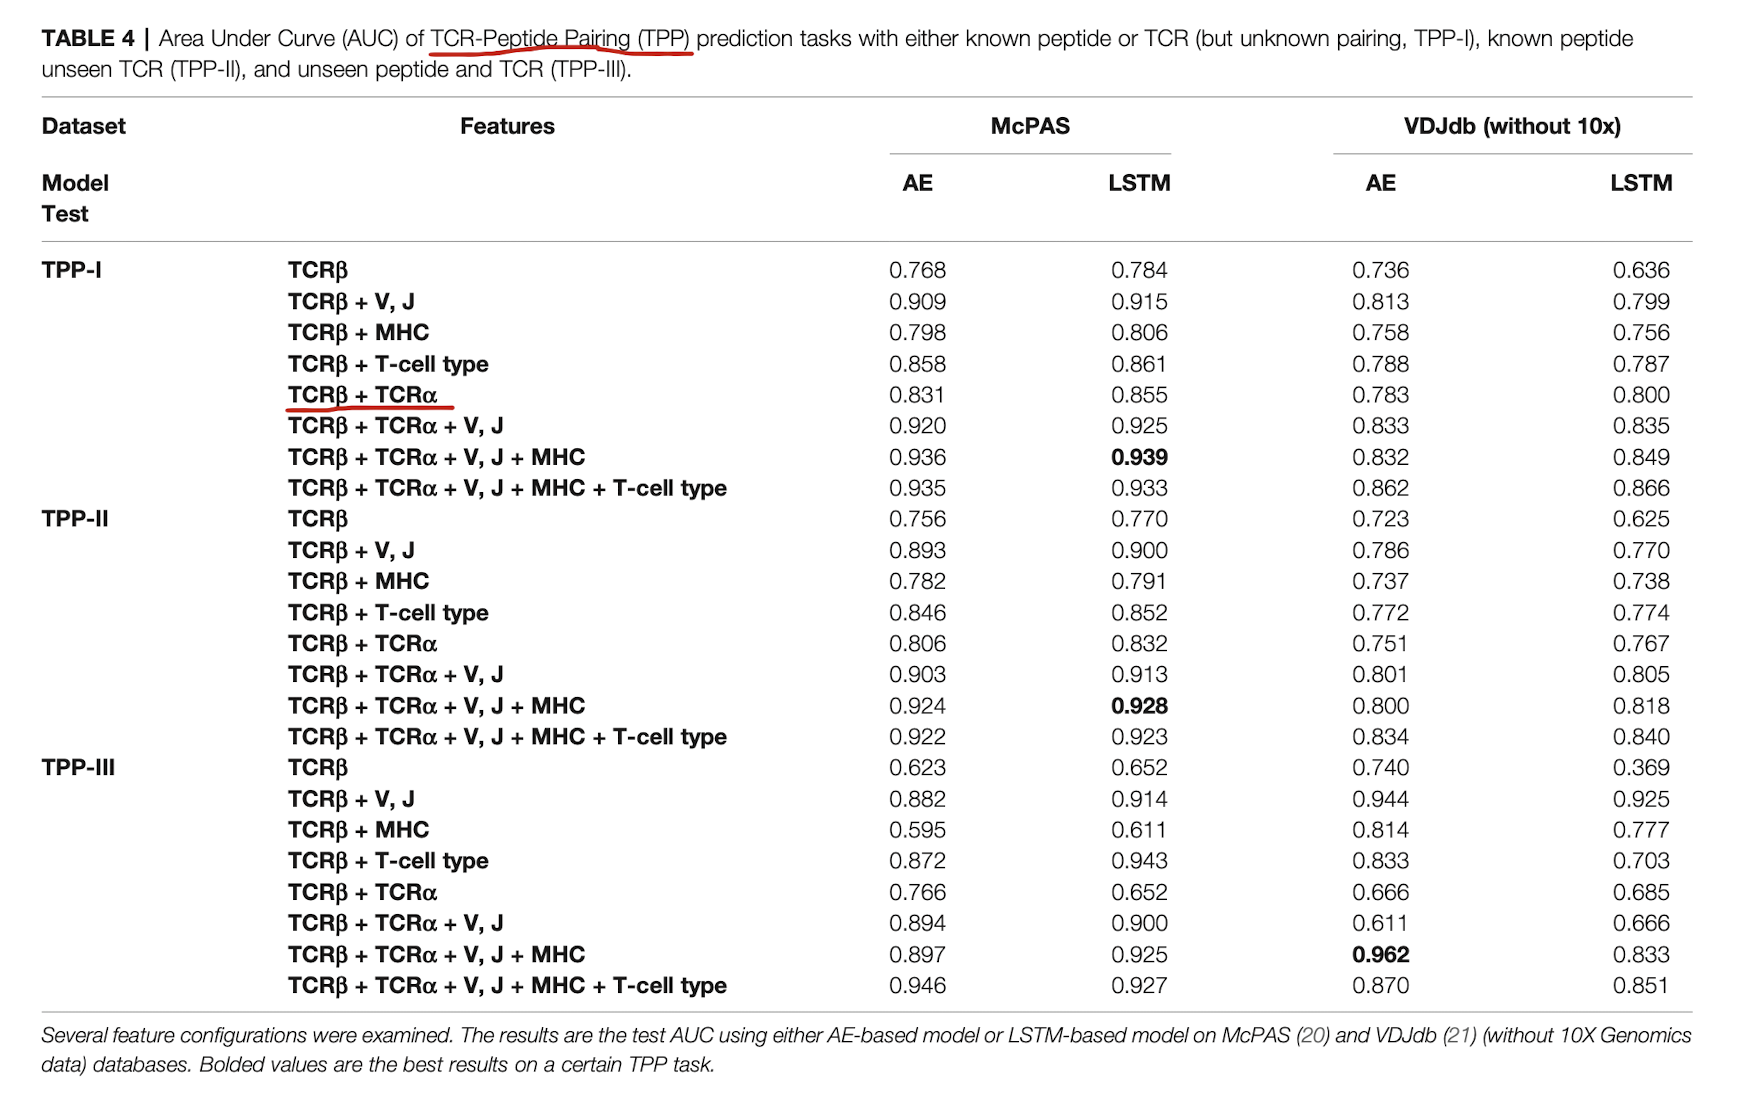

# McPAS

In [3]:
# pip3 install awscli &&\ 
# aws s3 sync s3://sg-playground-kkoyama-temp/tcrpred/hhyylog ~/jupyter_notebook/user_work/tcrpred/hhyylog

In [4]:
replace_tuple = ('~/jupyter_notebook/user_work/tcrpred/scripts/../log/', './../../hhyylog/')

logdf = pd.read_csv('files_jobid_MCPAS.csv')

files = [p.replace(replace_tuple[0], replace_tuple[1]).replace('_hh.csv', '_test_hh.csv')
          for p in logdf['hhpath'].values]

for f in files:
    newf = f.replace('.csv', '.parquet').replace('./../../hhyylog', 's3://tcrpred/tcrpred/hhyylog')
    df = pd.read_csv(f)
    df.to_parquet(newf)
    
    yy = pd.read_csv(f.replace('_hh.csv', '_yy.csv'))
    yy.to_parquet(newf.replace('_hh.', '_yy.'))
    

In [5]:

hhlist = [pd.read_csv(p.replace(replace_tuple[0], replace_tuple[1]).replace('_hh.csv', '_test_hh.csv')
                     ).apply(expit)
          for p in logdf['hhpath'].values]

hh_ave = pd.concat([h['1'] for h in hhlist], axis=1).mean(axis=1)

# hh_ave = hhlist[1]['1']

yy = pd.read_csv(
        logdf['yypath'].values[0]\
        .replace(replace_tuple[0], replace_tuple[1]).replace('_yy.csv', '_test_yy.csv')
                     )
yy = yy['0']
print(hh_ave.shape, yy.shape)

(5611,) (5611,)


In [6]:
hh_ave

0       0.918033
1       0.004177
2       0.097457
3       0.885176
4       0.002950
          ...   
5606    0.000520
5607    0.000206
5608    0.461246
5609    0.000190
5610    0.004910
Length: 5611, dtype: float64

In [7]:
roc_auc_score(y_true=yy, y_score=hh_ave)

0.9331086762999529

## Score by peptide type (in-train, not-in-train)

In [8]:
p_list = [f"../../external_data/ERGO-II/Samples/vdjdb_train_samples.pickle",
          f"../../external_data/ERGO-II/Samples/mcpas_train_samples.pickle",
        f"../../external_data/ERGO-II/Samples/vdjdb_test_samples.pickle",
          f"../../external_data/ERGO-II/Samples/mcpas_test_samples.pickle",]

df_mcpas_test = pd.DataFrame(pd.read_pickle(p_list[3])).query('tcra!="UNK"') #.query('sign==1')
df_mcpas_test['y_pred'] = hh_ave.values
df_mcpas_test['y_true'] = yy.values
df_mcpas_train = pd.DataFrame(pd.read_pickle(p_list[1])).query('tcra!="UNK"') #.query('sign==1')

df_mcpas_test['tcr_combined'] = df_mcpas_test['tcra'] + ":" + df_mcpas_test['tcrb']
df_mcpas_train['tcr_combined'] = df_mcpas_train['tcra'] + ":" + df_mcpas_train['tcrb']

df_mcpas_test['tcr_pep'] = df_mcpas_test['tcra'] + ":" + df_mcpas_test['tcrb'] + ":"  + df_mcpas_test['peptide']
df_mcpas_train['tcr_pep'] = df_mcpas_train['tcra'] + ":" + df_mcpas_train['tcrb']  + ":"  + df_mcpas_train['peptide']


## Score deduplicated

In [9]:
print("duplication as in tcra-tcrb-pep", df_mcpas_test.tcr_pep.isin(df_mcpas_train.tcr_pep).value_counts())

duplication as in tcra-tcrb-pep False    4729
True      882
Name: tcr_pep, dtype: int64


In [10]:
df_mcpas_test = df_mcpas_test[~df_mcpas_test.tcr_pep.isin(df_mcpas_train.tcr_pep)]

print("roc_auc_score",roc_auc_score(y_true=df_mcpas_test.y_true, y_score=df_mcpas_test.y_pred))

print("average_precision_score", average_precision_score(df_mcpas_test.y_true, df_mcpas_test.y_pred))

roc_auc_score 0.920217699589897
average_precision_score 0.6423617361176889


## Count overwapping

In [11]:
### Overwrapping Peptides
print("### Overwrapping Peptides")


print(df_mcpas_test.peptide.drop_duplicates().isin(df_mcpas_train.peptide).value_counts())

num_ow_pep = df_mcpas_test.peptide.drop_duplicates().isin(df_mcpas_train.peptide).value_counts().loc[True]
print()
print(f"There are {num_ow_pep} overwrapping peptide between training and test")



### Overwrapping TCRs
print("\n\n")
print("### Overwrapping TCRs")

print("Unique tcr_combined in train", df_mcpas_train.tcr_combined.nunique())
print("Unique tcr_combined in test", df_mcpas_test.tcr_combined.nunique())

print(df_mcpas_test.tcr_combined.drop_duplicates().isin(df_mcpas_train.tcr_combined).value_counts())

num_ow_tcrs = df_mcpas_test.tcr_combined.drop_duplicates().isin(df_mcpas_train.tcr_combined).value_counts().loc[True]
print()
print(f"There are {num_ow_tcrs} overwrapping peptide between training and test")

### Overwrapping Peptides
True     171
False     19
Name: peptide, dtype: int64

There are 171 overwrapping peptide between training and test



### Overwrapping TCRs
Unique tcr_combined in train 3181
Unique tcr_combined in test 833
False    701
True     132
Name: tcr_combined, dtype: int64

There are 132 overwrapping peptide between training and test


In [12]:
df_mcpas_train.peptide.nunique(), df_mcpas_test.peptide.nunique()

(316, 190)

In [13]:
df_mcpas_test.peptide.isin(df_mcpas_train.peptide).value_counts()

True     4683
False      46
Name: peptide, dtype: int64

In [14]:
df_mcpas_test['tcr_combined'] = df_mcpas_test['tcra'] + ":" + df_mcpas_test['tcrb']
df_mcpas_train['tcr_combined'] = df_mcpas_train['tcra'] + ":" + df_mcpas_train['tcrb']

print(df_mcpas_test.peptide.drop_duplicates().isin(df_mcpas_train.peptide).value_counts())

num_ow_pep = df_mcpas_test.peptide.drop_duplicates().isin(df_mcpas_train.peptide).value_counts().loc[True]
print(f"There are {num_ow_pep} overwrapping peptide between training and test")

print("Unique tcr_combined in train", df_mcpas_train.tcr_combined.nunique())

print("Unique tcr_combined in test", df_mcpas_test.tcr_combined.nunique())

print(df_mcpas_test.tcr_combined.drop_duplicates().isin(df_mcpas_train.tcr_combined).value_counts())

num_ow_tcrs = df_mcpas_test.tcr_combined.drop_duplicates().isin(df_mcpas_train.tcr_combined).value_counts().loc[True]

print(f"There are {num_ow_tcrs} overwrapping peptide between training and test")

True     171
False     19
Name: peptide, dtype: int64
There are 171 overwrapping peptide between training and test
Unique tcr_combined in train 3181
Unique tcr_combined in test 833
False    701
True     132
Name: tcr_combined, dtype: int64
There are 132 overwrapping peptide between training and test


In [15]:
df_valid_not_in_train = df_mcpas_test[~df_mcpas_test.peptide.isin(df_mcpas_train.peptide)]
df_valid_in_train = df_mcpas_test[df_mcpas_test.peptide.isin(df_mcpas_train.peptide)]


In [16]:
print('unique peptide count pep in-train', df_valid_in_train.peptide.nunique())
print('unique peptide count pep not-in-train', df_valid_not_in_train.peptide.nunique())
print('interaction count pep in-train', df_valid_in_train.shape[0])
print('interaction count pep not-in-train', df_valid_not_in_train.shape[0])

unique peptide count pep in-train 171
unique peptide count pep not-in-train 19
interaction count pep in-train 4683
interaction count pep not-in-train 46


In [17]:
print("negative_positive_ratio =",df_mcpas_test.y_true.value_counts().to_dict())

negative_positive_ratio = {0: 4014, 1: 715}


In [18]:
df_mcpas_test.peptide.value_counts()

LPRRSGAAGA                   569
GILGFVFTL                    474
GLCTLVAML                    288
SSYRRPVGI                    277
NLVPMVATV                    227
                            ... 
ILIVMVPFL                      1
FLRGRAYGL                      1
ILYCKRASLTELVSPRLPSHLSEYE      1
YLLPAIVHI                      1
FLWSVFMLI                      1
Name: peptide, Length: 190, dtype: int64

negative_positive_ratio = {0: 32, 1: 14}
- acc 0.6739130434782609
- balanced_acc 0.6049107142857143
- precision on 1:  0.46153846153846156
- precision on 0:  0.7575757575757576
- confusion matrix tn, fp, fn, tp: 25, 7, 8, 6
- roc_auc_score 0.7209821428571428
- pr_auc_score on 1 0.4827983177762295
- pr_auc_score on 0 0.8739226618024295


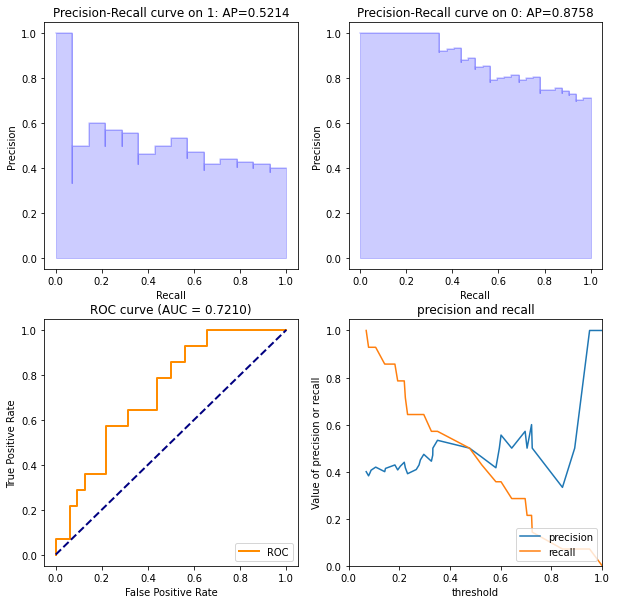

****************************************************************************************************
0    3982
1     701
Name: y_true, dtype: int64
- acc 0.8806320734571855
- balanced_acc 0.8105056921625202
- precision on 1:  0.5831381733021077
- precision on 0:  0.946983546617916
- confusion matrix tn, fp, fn, tp: 3626, 356, 203, 498
- roc_auc_score 0.9218437318862126
- pr_auc_score on 1 0.6441478253667355
- pr_auc_score on 0 0.9853586816754504


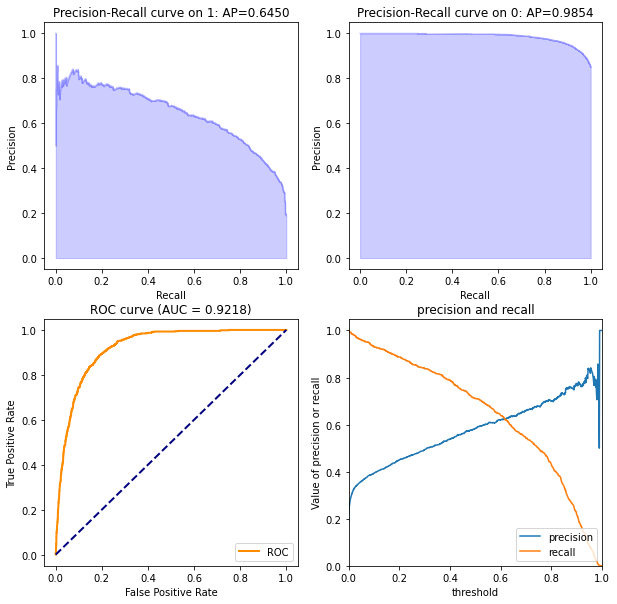

In [19]:

print("negative_positive_ratio =",df_valid_not_in_train.y_true.value_counts().to_dict())

get_infer_report(df_valid_not_in_train.y_true, df_valid_not_in_train.y_pred)

print('*'*100)
print(df_valid_in_train.y_true.value_counts())
get_infer_report(df_valid_in_train.y_true, df_valid_in_train.y_pred)

In [20]:
THH = 0.5
print(sum(df_valid_not_in_train.y_pred>THH))
df_valid_not_in_train[(df_valid_not_in_train.y_true==1) & (df_valid_not_in_train.y_pred>THH)]

13


,tcra,tcrb,va,ja,vb,jb,t_cell_type,peptide,protein,mhc,sign,y_pred,y_true,tcr_combined,tcr_pep
4516,CAVKGEGGGADGLTF,CASNLQRAVNTEAF,NaN,NaN,NaN,NaN,CD4,PGISSQHFTYQGGVGGSWPVCSGLG,PLXB,NaN,1,0.950278,1,CAVKGEGGGADGLTF:CASNLQRAVNTEAF,CAVKGEGGGADGLTF:CASNLQRAVNTEAF:PGISSQHFTYQGGVG...
7296,CAASTGGGNKLTF,CSAREGAGGMGTQYF,NaN,NaN,NaN,NaN,CD4,MTEYKLVVVGADGVGKSALTIQLI,KRAS,NaN,1,0.601148,1,CAASTGGGNKLTF:CSAREGAGGMGTQYF,CAASTGGGNKLTF:CSAREGAGGMGTQYF:MTEYKLVVVGADGVGK...
9474,CAFTSGNQFYF,CATQWTGGHEQYF,TRAV24,NaN,TRBV2,NaN,NaN,RLHDLVLPL,PELP1-RLH,HLA-A2,1,0.525455,1,CAFTSGNQFYF:CATQWTGGHEQYF,CAFTSGNQFYF:CATQWTGGHEQYF:RLHDLVLPL
12607,CAVRDQSNQFYF,CSVRVGTQYF,TRAV1-2,NaN,TRBV29-1,NaN,NaN,FSSEVLNLV,IPO9-FSS,HLA-A2,1,0.721489,1,CAVRDQSNQFYF:CSVRVGTQYF,CAVRDQSNQFYF:CSVRVGTQYF:FSSEVLNLV
12723,CATDALSGTYKYIF,CASSVDGTEETQYF,TRAV17,NaN,TRBV9,NaN,NaN,FLMASISSS,SSPN-9,HLA-A2,1,0.696131,1,CATDALSGTYKYIF:CASSVDGTEETQYF,CATDALSGTYKYIF:CASSVDGTEETQYF:FLMASISSS
13826,CAISMDTGRRALTF,CASSEMDGSNQPQHF,TRAV12-3,NaN,TRBV6-1,NaN,NaN,FIMGISILL,IL17RA-FIT-TM,HLA-A2,1,0.724145,1,CAISMDTGRRALTF:CASSEMDGSNQPQHF,CAISMDTGRRALTF:CASSEMDGSNQPQHF:FIMGISILL


## Score by each peptide

In [21]:

# assuming df_mcpas_test is your DataFrame and it has columns 'peptide', 'y_true', 'y_pred'

metrics = []
for pep in df_mcpas_test.peptide.value_counts().index:
    group = df_mcpas_test.query(f'peptide=="{pep}"')
    
    if (group['y_true'].mean()==0) or (group['y_true'].mean()==1.0):
        roc_auc = None
        avg_precision = None
    else:
        roc_auc = roc_auc_score(group['y_true'], group['y_pred'])
        avg_precision = average_precision_score(group['y_true'], group['y_pred'])
    
    positive_rate = group['y_true'].mean()  # assuming y_true is binary (0 or 1)
    number_of_peptide = group.shape[0]
    
    metrics.append({
        'peptide': pep,
        'average_precision': avg_precision,
        'roc_auc': roc_auc,
        'positive_rate': positive_rate,
        'number_of_peptide': number_of_peptide
    })

metrics_df_mcpas_test = pd.DataFrame(metrics)

display(metrics_df_mcpas_test.head(10))

,peptide,average_precision,roc_auc,positive_rate,number_of_peptide
0,LPRRSGAAGA,NaN,NaN,0.000000,569
1,GILGFVFTL,0.478740,0.823372,0.200422,474
2,GLCTLVAML,0.502566,0.877323,0.065972,288
3,SSYRRPVGI,0.754481,0.874958,0.368231,277
4,NLVPMVATV,0.564592,0.848618,0.123348,227
5,SSLENFRAYV,0.765481,0.858165,0.343750,192
6,ASNENMETM,0.690154,0.871180,0.233333,150
7,CRVLCCYVL,NaN,NaN,0.000000,150
8,LLWNGPMAV,0.761807,0.875640,0.336066,122
9,HGIRNASFI,0.868418,0.940708,0.319328,119


# VDJDB

In [22]:
replace_tuple = ('~/jupyter_notebook/user_work/tcrpred/scripts/../log/', './../../hhyylog/')
logdf = pd.read_csv('./comparison_ergo/files_jobid20210916030915vdjdbno10x_v1.csv')

files = [p.replace(replace_tuple[0], replace_tuple[1]).replace('_hh.csv', '_test_hh.csv')
         for p in logdf['hhpath'].values]

for f in files:
    newf = f.replace('.csv', '.parquet').replace('./../../hhyylog', 's3://tcrpred/tcrpred/hhyylog')
    df = pd.read_csv(f)
    
    newf = f.replace('.csv', '.parquet').replace('./../../hhyylog', 's3://tcrpred/tcrpred/hhyylog')
    df = pd.read_csv(f)
    
    df.to_parquet(newf)
    
    yy = pd.read_csv(f.replace('_hh.csv', '_yy.csv'))
    yy.to_parquet(newf.replace('_hh.', '_yy.'))

# newf

In [21]:

hhlist = [pd.read_csv(
    p.replace(replace_tuple[0], replace_tuple[1]).replace('_hh.csv', '_test_hh.csv')
                     ).apply(expit)
          for p in logdf['hhpath'].values]

hh_ave = pd.concat([h['1'] for h in hhlist], axis=1).mean(axis=1)

# hh_ave = hhlist[1]['1']


yy = pd.read_csv(
        logdf['yypath'].values[0]\
        .replace(replace_tuple[0], replace_tuple[1]).replace('_yy.csv', '_test_yy.csv')
                     )
yy = yy['0']

print(hh_ave.shape, yy.shape)

(4485,) (4485,)


In [22]:
df_mcpas_test = df_mcpas_test[~df_mcpas_test.tcr_pep.isin(df_mcpas_train.tcr_pep)]

roc_auc_score(y_true=df_mcpas_test.y_true, y_score=df_mcpas_test.y_pred)

0.920217699589897

In [23]:
roc_auc_score(y_true=yy, y_score=hh_ave)

0.9255641285527564

In [24]:
# !mv ../../hhyylog/20210911_043036_k0_hh.csv ../../hhyylog/20210911_043036_k0_test_hh.csv 
# !mv ../../hhyylog/20210911_043036_k0_yy.csv ../../hhyylog/20210911_043036_k0_test_yy.csv 

In [25]:
p_list = [
    f"../../external_data/ERGO-II/Samples/vdjdb_no10x_train_samples.pickle",
    f"../../external_data/ERGO-II/Samples/vdjdb_no10x_test_samples.pickle",
         ]

df_vdjdb_test = pd.DataFrame(pd.read_pickle(p_list[1])).query('tcra!="UNK"') #.query('sign==1')
df_vdjdb_test['y_pred'] = hh_ave.values
df_vdjdb_test['y_true'] = yy.values

df_vdjdb_train = pd.DataFrame(pd.read_pickle(p_list[0])).query('tcra!="UNK"') #.query('sign==1')


df_vdjdb_test['tcr_combined'] = df_vdjdb_test['tcra'] + ":" + df_vdjdb_test['tcrb']
df_vdjdb_train['tcr_combined'] = df_vdjdb_train['tcra'] + ":" + df_vdjdb_train['tcrb']

df_vdjdb_test['tcr_pep'] = df_vdjdb_test['tcra'] + ":" + df_vdjdb_test['tcrb'] + ":"  + df_vdjdb_test['peptide']
df_vdjdb_train['tcr_pep'] = df_vdjdb_train['tcra'] + ":" + df_vdjdb_train['tcrb']  + ":"  + df_vdjdb_train['peptide']

print("duplication as in tcra-tcrb-pep", df_vdjdb_test.tcr_pep.isin(df_vdjdb_train.tcr_pep).value_counts())

df_vdjdb_test = df_vdjdb_test[~df_vdjdb_test.tcr_pep.isin(df_vdjdb_train.tcr_pep)]

print("duplication as in tcra-tcrb-pep", df_vdjdb_test.tcr_pep.isin(df_vdjdb_train.tcr_pep).value_counts())

print(
    "roc_auc_score(withtout duplication) = ", roc_auc_score(y_true=df_vdjdb_test.y_true, y_score=df_vdjdb_test.y_pred)
)
print(
    "average_precision_score = ", average_precision_score(y_true=df_vdjdb_test.y_true, y_score=df_vdjdb_test.y_pred)
    
)


duplication as in tcra-tcrb-pep False    4010
True      475
Name: tcr_pep, dtype: int64
duplication as in tcra-tcrb-pep False    4010
Name: tcr_pep, dtype: int64
roc_auc_score(withtout duplication) =  0.9220529774569086
average_precision_score =  0.6738312814717726


In [26]:
df_vdjdb_test.columns

Index(['tcrb', 'tcra', 'va', 'ja', 'vb', 'jb', 'peptide', 'protein', 'mhc',
       't_cell_type', 'sign', 'y_pred', 'y_true', 'tcr_combined', 'tcr_pep'],
      dtype='object')

In [27]:
df_vdjdb_test.rename(
    columns={"tcra":"CDR3a", "tcrb":"CDR3b", "peptide":"peptide", "y_true":"binder"}
)[["CDR3a", "CDR3b", "peptide", "binder"]].to_csv("/Users/kyoheikoyama/workspace/NetTCR-2.0/test/df_vdjdb_test.csv")

df_vdjdb_train.rename(
    columns={"tcra":"CDR3a", "tcrb":"CDR3b", "peptide":"peptide", "sign":"binder"}
)[["CDR3a", "CDR3b", "peptide", "binder"]].to_csv("/Users/kyoheikoyama/workspace/NetTCR-2.0/test/df_vdjdb_train.csv")


df_mcpas_test.rename(
    columns={"tcra":"CDR3a", "tcrb":"CDR3b", "peptide":"peptide", "y_true":"binder"}
)[["CDR3a", "CDR3b", "peptide", "binder"]].to_csv("/Users/kyoheikoyama/workspace/NetTCR-2.0/test/df_mcpas_test.csv")

df_mcpas_train.rename(
    columns={"tcra":"CDR3a", "tcrb":"CDR3b", "peptide":"peptide", "sign":"binder"}
)[["CDR3a", "CDR3b", "peptide", "binder"]].to_csv("/Users/kyoheikoyama/workspace/NetTCR-2.0/test/df_mcpas_train.csv")


In [28]:
df_mcpas_train.peptide.apply(len).max()

25

In [29]:
print("value_counts()", df_vdjdb_test.peptide.isin(df_vdjdb_train.peptide).value_counts())

df_valid_not_in_train = df_vdjdb_test[~df_vdjdb_test.peptide.isin(df_vdjdb_train.peptide)]
df_valid_in_train = df_vdjdb_test[df_vdjdb_test.peptide.isin(df_vdjdb_train.peptide)]


value_counts() True     3994
False      16
Name: peptide, dtype: int64


In [30]:
print('unique peptide count pep in-train', df_valid_in_train.peptide.nunique())
print('unique peptide count pep not-in-train', df_valid_not_in_train.peptide.nunique())

print('interaction count pep in-train', df_valid_in_train.shape[0])
print('interaction count pep not-in-train', df_valid_not_in_train.shape[0])


unique peptide count pep in-train 111
unique peptide count pep not-in-train 8
interaction count pep in-train 3994
interaction count pep not-in-train 16


negative_positive_ratio = {0: 8, 1: 8}
- acc 0.625
- balanced_acc 0.625
- precision on 1:  0.6666666666666666
- precision on 0:  0.6
- confusion matrix tn, fp, fn, tp: 6, 2, 4, 4
- roc_auc_score 0.71875
- pr_auc_score on 1 0.7171479562104562
- pr_auc_score on 0 0.7731856684981684


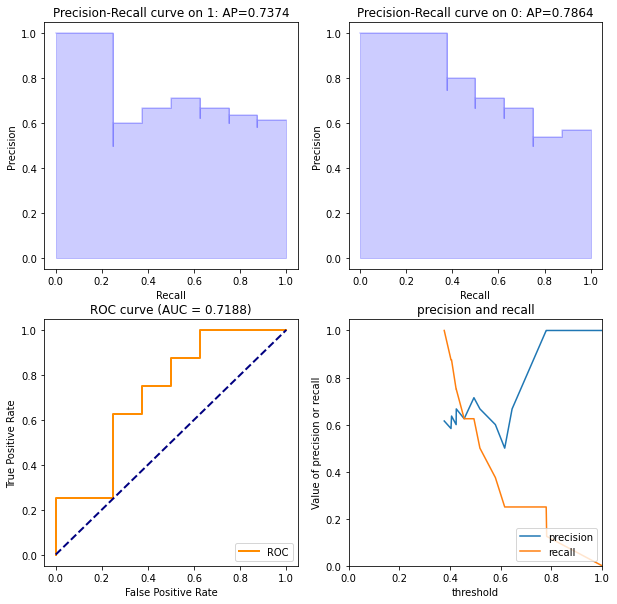

****************************************************************************************************
0    3399
1     595
Name: y_true, dtype: int64
- acc 0.7080620931397096
- balanced_acc 0.8132278153980039
- precision on 1:  0.3337216074548631
- precision on 0:  0.9903381642512077
- confusion matrix tn, fp, fn, tp: 2255, 1144, 22, 573
- roc_auc_score 0.9257532492255509
- pr_auc_score on 1 0.6764588390275834
- pr_auc_score on 0 0.9851488578779163


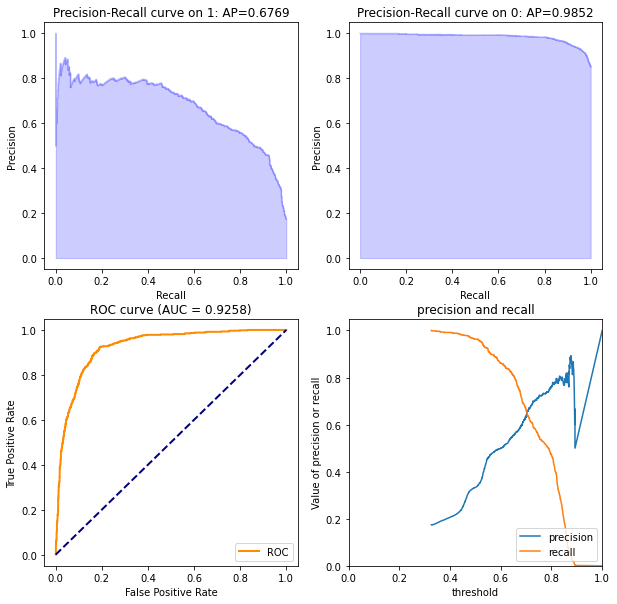

In [31]:

print("negative_positive_ratio =",df_valid_not_in_train.y_true.value_counts().to_dict())

get_infer_report(df_valid_not_in_train.y_true, df_valid_not_in_train.y_pred)

print('*'*100)
print(df_valid_in_train.y_true.value_counts())
get_infer_report(df_valid_in_train.y_true, df_valid_in_train.y_pred)

# Our model

In [32]:
df_mcpas_test = df_mcpas_test[~df_mcpas_test.tcr_pep.isin(df_mcpas_train.tcr_pep)]

print("roc_auc_score",roc_auc_score(y_true=df_mcpas_test.y_true, y_score=df_mcpas_test.y_pred))

print("average_precision_score", average_precision_score(df_mcpas_test.y_true, df_mcpas_test.y_pred))

roc_auc_score 0.920217699589897
average_precision_score 0.6423617361176889


In [33]:

df_vdjdb_test = df_vdjdb_test[~df_vdjdb_test.tcr_pep.isin(df_vdjdb_train.tcr_pep)]

print("duplication as in tcra-tcrb-pep", df_vdjdb_test.tcr_pep.isin(df_vdjdb_train.tcr_pep).value_counts())

print(
    "roc_auc_score(withtout duplication) = ", roc_auc_score(y_true=df_vdjdb_test.y_true, y_score=df_vdjdb_test.y_pred)
)
print(
    "average_precision_score = ", average_precision_score(y_true=df_vdjdb_test.y_true, y_score=df_vdjdb_test.y_pred)
    
)


duplication as in tcra-tcrb-pep False    4010
Name: tcr_pep, dtype: int64
roc_auc_score(withtout duplication) =  0.9220529774569086
average_precision_score =  0.6738312814717726


# Net TCR 2.0

In [23]:
df_mcpas_nettcr = pd.read_csv("~/workspace/NetTCR-2.0/mcpas.csv")
df_mcpas_nettcr['y_true'] = df_mcpas_nettcr.binder
df_mcpas_nettcr['y_pred'] = df_mcpas_nettcr.prediction

df_mcpas_nettcr.to_parquet("./../data/nettcr2_mcpas.paruqet")

print(len(df_mcpas_nettcr))

print("roc_auc_score", 
      roc_auc_score(df_mcpas_nettcr.binder, df_mcpas_nettcr.prediction, ))


print("average_precision_score", 
      average_precision_score(df_mcpas_nettcr.binder, df_mcpas_nettcr.prediction, ))

4729
roc_auc_score 0.920447489730001
average_precision_score 0.5808204714703076


In [24]:
df_vdjdb_nettcr = pd.read_csv("~/workspace/NetTCR-2.0/vdjdb.csv")
df_vdjdb_nettcr['y_true'] = df_vdjdb_nettcr.binder
df_vdjdb_nettcr['y_pred'] = df_vdjdb_nettcr.prediction

df_vdjdb_nettcr.to_parquet("./../data/nettcr2_vdjdb.paruqet")

print(len(df_vdjdb_nettcr), )

print("roc_auc_score", 
      roc_auc_score(df_vdjdb_nettcr.binder, df_vdjdb_nettcr.prediction, ))

print("average_precision_score", 
      average_precision_score(df_vdjdb_nettcr.binder, df_vdjdb_nettcr.prediction, ))

4010
roc_auc_score 0.9492097773533272
average_precision_score 0.7261557306023951


In [36]:
# 4010
# roc_auc_score 0.9492097773533272
# average_precision_score 0.7261557306023951


# Per peptide

In [62]:
def show_score_by_each_peptide(df_mcpas_test, peps):
    metrics = []
    for pep in peps:
        group = df_mcpas_test.query(f'peptide=="{pep}"')
        
        if len(group)==0:
            continue
            
        if (group['y_true'].mean()==0) or (group['y_true'].mean()==1.0):
            roc_auc = None
            avg_precision = None
        else:
            roc_auc = roc_auc_score(group['y_true'], group['y_pred'])
            avg_precision = average_precision_score(group['y_true'], group['y_pred'])

        positive_rate = group['y_true'].mean()  # assuming y_true is binary (0 or 1)
        number_of_peptide = group.shape[0]

        metrics.append({
            'peptide': pep,
            'average_precision': avg_precision,
            'roc_auc': roc_auc,
            'positive_rate': positive_rate,
            '#_of_interactions': number_of_peptide
        })
        
    metrics_df_mcpas_test = pd.DataFrame(metrics)
    display(metrics_df_mcpas_test.head(3))
    return metrics_df_mcpas_test


## McPAS

In [72]:
peps = df_mcpas_test.peptide.value_counts().head(10).index

ours = show_score_by_each_peptide(df_mcpas_test, peps)

ours = ours.rename(columns={'average_precision':'OurModel AP', 
                            'roc_auc':'OurModel ROCAUC', 
                    })

theirs = show_score_by_each_peptide(df_mcpas_nettcr, peps)

theirs = theirs.rename(columns={'average_precision':'NetTCR2.0 AP', 
                     'roc_auc':'NetTCR2.0 ROCAUC', 
                    }).drop(columns=['peptide','positive_rate', '#_of_interactions'])

show1 = pd.concat([ours, theirs], axis=1).dropna()

,peptide,average_precision,roc_auc,positive_rate,#_of_interactions
0,LPRRSGAAGA,NaN,NaN,0.000000,569
1,GILGFVFTL,0.478740,0.823372,0.200422,474
2,GLCTLVAML,0.502566,0.877323,0.065972,288


,peptide,average_precision,roc_auc,positive_rate,#_of_interactions
0,LPRRSGAAGA,NaN,NaN,0.000000,569
1,GILGFVFTL,0.496773,0.843633,0.200422,474
2,GLCTLVAML,0.506201,0.932107,0.065972,288


In [73]:
# a[['OurModel ROCAUC', 'NetTCR2.0 ROCAUC', 'positive_rate']].plot.bar(secondary_y=['positive_rate'])

## VDJDB

In [74]:
peps = df_mcpas_test.peptide.value_counts().head(10).index

ours = show_score_by_each_peptide(df_vdjdb_test, peps)
ours = ours.rename(columns={'average_precision':'OurModel AP', 
                     'roc_auc':'OurModel ROCAUC', 
                    })

theirs = show_score_by_each_peptide(df_vdjdb_nettcr, peps)

theirs = theirs.rename(columns={'average_precision':'NetTCR2.0 AP', 
                     'roc_auc':'NetTCR2.0 ROCAUC', 
                    }).drop(columns=['peptide','positive_rate', '#_of_interactions'])

show2 = pd.concat([ours, theirs], axis=1).dropna()

,peptide,average_precision,roc_auc,positive_rate,#_of_interactions
0,LPRRSGAAGA,NaN,NaN,0.000000,16
1,GILGFVFTL,0.420246,0.809821,0.176923,520
2,GLCTLVAML,0.573808,0.915812,0.103960,202


,peptide,average_precision,roc_auc,positive_rate,#_of_interactions
0,LPRRSGAAGA,NaN,NaN,0.000000,16
1,GILGFVFTL,0.596851,0.886441,0.176923,520
2,GLCTLVAML,0.580583,0.946988,0.103960,202


(0.0, 1000.0)

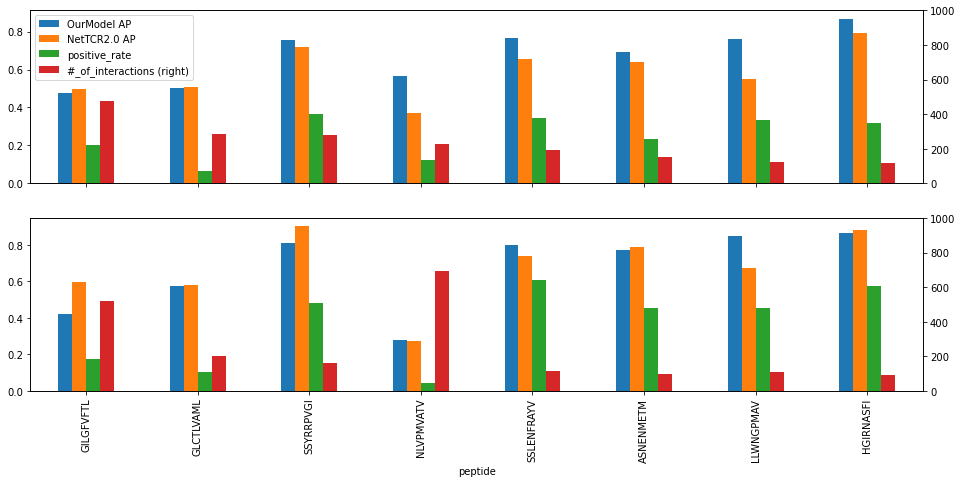

In [91]:
fig, (ax1, ax2) = plt.subplots(2,1)
show1.index = show1.peptide
show1[['OurModel AP', 'NetTCR2.0 AP', 'positive_rate', '#_of_interactions']].plot.bar(
    secondary_y=['#_of_interactions'], ax=ax1, figsize=(16,7), 
)
ax1.right_ax.set_ylim(0,1000)
ax1.set_xticklabels(labels=list(''*len(show1)))
ax1.set_xlabel('')
# ax1.legend_(1)
# ax1.set_title('')

show2.index = show2.peptide
show2[['OurModel AP', 'NetTCR2.0 AP', 'positive_rate', '#_of_interactions']].plot.bar(
    secondary_y=['#_of_interactions'], ax=ax2, figsize=(16,7), 
    legend=False
)
ax2.right_ax.set_ylim(0,1000)

